# Customer Segmentation and Profiling

- Customer profiling, is the process of defining the ideal customer(s), based on a set of unique characteristics. This includes information on their demographics, behavior patterns, purchased products, and order history. The most popular way of defining your customer profile is by creating buyer personas - semi-fictional characters. These personas describe the nature of customers found in such groups.

- Whereas Customer segmentation, on the other hand, is all about splitting your existing customer pool into more specific subgroups. Each of these smaller groups shares unique characteristics based on information collected from existing data.

- Here the goal is to be able to perform both using the dataset.

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', 150)

import gc
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#import utility functions from script
from utils import *

#configure plots from matplotlib
matplotlib.rcParams['figure.dpi'] = 180 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

#set seaborn style for plots
sns.set_style('darkgrid')

color = sns.color_palette()

#Data file directory
root = 'C:/Users/ALEXANDER/Documents/Machine Learning/Instacart/Data/'

##Ignore Warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Read datasets
aisles = read(root,path='aisles')
departments = read(root,path='departments')
orders = read(root,path='orders')
order_products_prior = read(root,path='order_products__prior')
order_products_train = read(root,path='order_products__train')
products = read(root,path="products")

For Customer segmentation, I will consider the prior set only. Since this dataset represents the sales and behavioral history of customers before analysis.

In [3]:
combined_order = order_products_prior.merge(products, on ='product_id', how='left')
combined_order = combined_order.merge(aisles, on ='aisle_id', how='left')
combined_order = combined_order.merge(departments, on ='department_id', how='left')
combined_order = combined_order.merge(orders, on='order_id', how='left')
combined_order.shape

(32434489, 15)

In [4]:
print(f"There are exactly {combined_order['user_id'].nunique()} customers in the prior dataset")

There are exactly 206209 customers in the prior dataset


The goal is to create several `customer cohorts`, where each cohort represents behavioral similarities on the basis of products purchased together. i.e customers with similar puchasing behavior should be grouped into the same cohort.

To do this, the product feature is unreliable as their to many groups of product, another level for categorizing products is `aisle`. Hence, we will try to segment customer into cohorts based on the purchasing history with respect to `aisles or shelves`. Since the `aisles` feature has many categories, I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

In [5]:
cross_df = pd.crosstab(combined_order['user_id'], combined_order['aisle'])
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


- Before PCA, to speed up computation. It is desirable that the data be normalized.

In [6]:
#Normalized aisle count.
normalized_df = cross_df.div(cross_df.sum(axis=1), axis=0)
normalized_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016949,0.0,0.000000,0.0,0.000000,0.0,0.050847,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.033898,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084746,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.152542,0.000000,0.000000,0.0,0.000000,0.135593,0.0,0.000000,0.0,0.0,0.000000,0.033898,0.0,0.000000,0.000000,0.203390,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220339,0.000000,0.033898,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,0.0,0.005128,0.005128,0.010256,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.005128,0.0,0.000000,0.061538,0.0,0.0,0.0,0.0,0.025641,0.0,0.056410,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.030769,0.0,0.0,0.0,0.0,0.0,0.0,0.046154,0.169231,0.000000,0.000000,0.000000,0.0,0.005128,0.000000,0.0,0.0,0.061538,0.0,0.0,0.0,0.020513,0.0,0.0,0.005128,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.005128,0.0,0.0,0.0,0.0,0.051282,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.015385,0.000000,0.005128,0.0,0.000000,0.025641,0.0,0.005128,0.0,0.0,0.015385,0.000000,0.0,0.005128,0.000000,0.051282,0.0,0.000000,0.005128,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005128,0.0,0.000000,0.0,0.0,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.

In [7]:
normalized_df.shape[1]

134

- However the dimensions (`aisle` categories) are still too many. So I will apply PCA to reduce the dimensions before clustering.

## PCA and K-Means Clustering

- By applying PCA, I will reduce the dimensionality of the data, thereby increasing interpretability but at the same time minimizing information loss.
- Reducing this dataframe to only 10 dimensions as the clustering algorithm I intend to use does not work properly in higher dimension.

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

In [9]:
PCA_transformer = PCA(n_components=10,random_state=21)
reduced_df = PCA_transformer.fit_transform(normalized_df)
reduced_df = pd.DataFrame(reduced_df)

#Preview dimensionally reduced dataset
reduced_df.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018864,-0.088341,-0.104576,-0.116491,0.083746,-0.063210,-0.026412
1,-0.036988,0.108884,-0.066406,-0.123271,0.098847,-0.033959,-0.054754,-0.053322,-0.020410,-0.008587
2,0.064282,0.103962,0.000710,-0.012221,-0.046984,0.112231,-0.029826,0.007923,0.012009,0.001422
3,-0.093210,0.054093,0.001867,-0.003973,-0.071358,-0.019270,-0.025116,-0.038237,0.006614,-0.000561
4,0.094629,-0.037051,-0.024952,-0.021574,0.055368,0.107651,-0.008043,0.103939,0.051750,-0.025993


## Clustering

- The goal is to segment customers into k number of clusters. 
- A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.
- The optimal number of clusters will be selected using `Inertia`. Inertia refers to the sum of squared distances of samples to their closest cluster center.

In [10]:
inertia = []
cluster_search_space = range(1,10)
for n_clusters in cluster_search_space:
    estimator = KMeans(n_clusters=n_clusters,random_state=2)
    estimator = estimator.fit(reduced_df)
    inertia.append(estimator.inertia_)

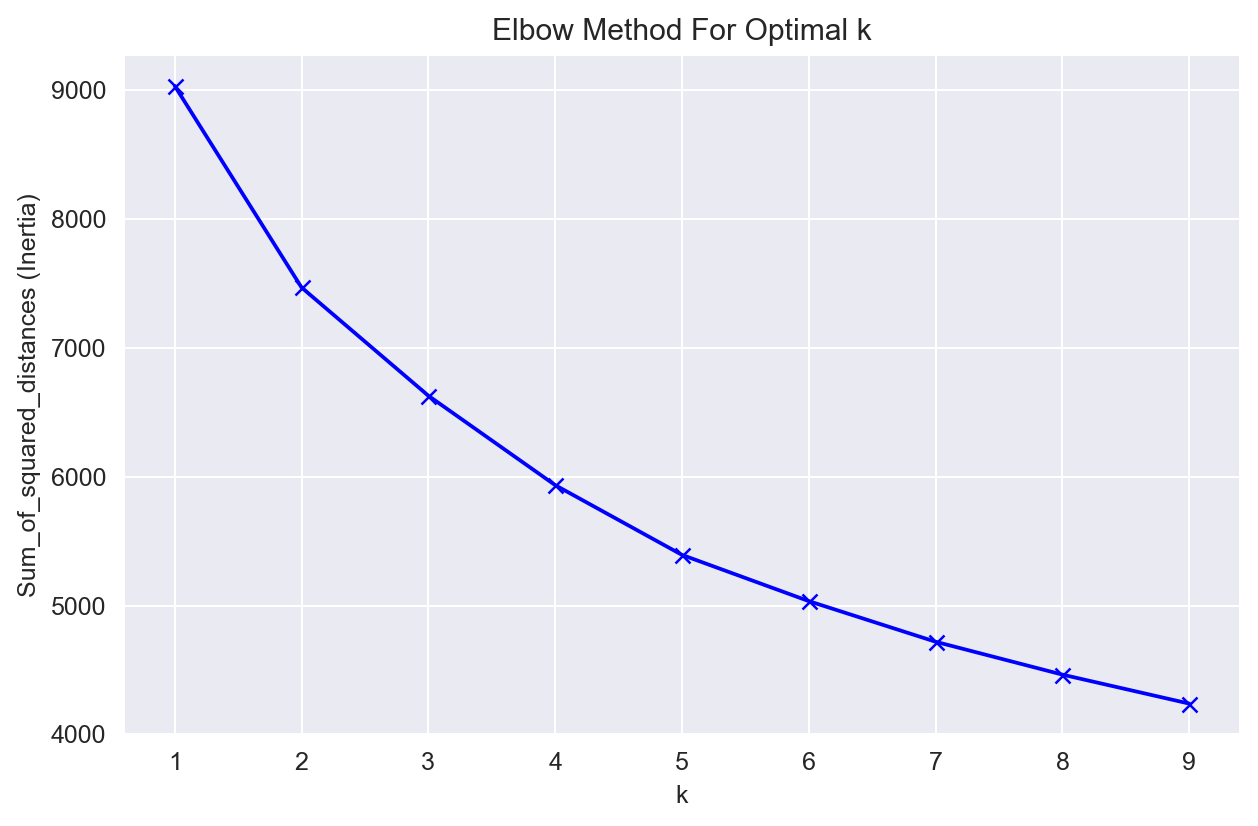

In [13]:
#Visualize sum of squared distances as k increases
plt.subplots(figsize = (8, 5))
plt.plot(cluster_search_space, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

- From the figure above we can deduce that the optimal value of K is 5.

In [15]:
#Re-initialize model and perform customer segmentation
estimator = KMeans(n_clusters=5,random_state=2).fit(reduced_df)
customer_centers = estimator.cluster_centers_
predicted_segments = estimator.predict(reduced_df)
print(customer_centers)

[[ 1.05525470e-01 -7.30578127e-02  1.72456731e-02  3.66835881e-03
   1.76659711e-03 -4.42370208e-03 -9.45345903e-04  1.29701803e-03
  -1.74546843e-04  7.65182118e-04]
 [-7.38915401e-02 -1.05647591e-02 -2.70103641e-02 -7.01147237e-03
  -6.74896059e-03  1.54784405e-03  5.01247917e-04 -2.53092136e-03
  -3.22041597e-04 -4.03512666e-04]
 [-1.98272709e-01  1.61722606e-02  3.17199954e-01 -3.14074467e-02
   1.87306841e-02  6.17048021e-04  4.08087568e-03  1.08889604e-02
   1.13145080e-03 -3.83775551e-03]
 [ 6.76242058e-02  1.05950381e-01 -1.11120853e-03 -3.09403341e-02
  -1.07610408e-02  7.18249551e-03 -5.22440131e-04  4.51061806e-03
  -7.07939920e-04 -1.62935029e-04]
 [-6.14576086e-03  1.30681530e-01  4.86043368e-03  2.30150266e-01
   1.10160833e-01 -2.27768288e-02  9.30338279e-05 -6.40157624e-03
   7.83808306e-03  3.04582252e-03]]


- Let's visualize the predicted customer segments around the first two principal components

In [16]:
new_data = reduced_df.iloc[:, :2]
new_data.columns = ["f1", "f2"]
new_data['customer segment'] = predicted_segments
new_data.head()

,f1,f2,customer segment
0,-0.113443,0.039084,1
1,-0.036988,0.108884,3
2,0.064282,0.103962,3
3,-0.093210,0.054093,1
4,0.094629,-0.037051,0


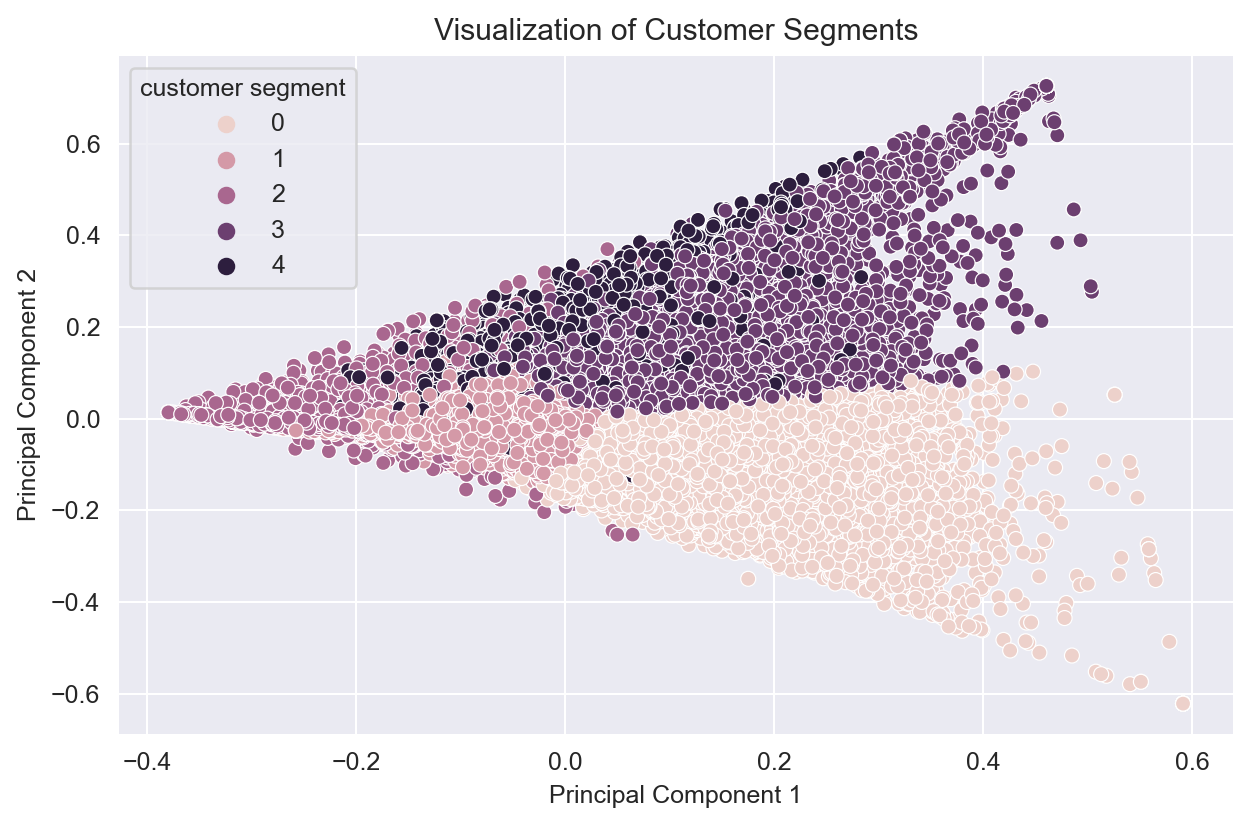

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = new_data, x = "f1", y = "f2", hue = "customer segment")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Visualization of Customer Segments")
plt.show()

In [19]:
cross_df['customer_segment'] = predicted_segments

cohort1 = cross_df[cross_df['customer_segment']  == 0]
cohort2 = cross_df[cross_df['customer_segment']  == 1]
cohort3 = cross_df[cross_df['customer_segment'] == 2]
cohort4 = cross_df[cross_df['customer_segment']  == 3]
cohort5 = cross_df[cross_df['customer_segment']  == 4]

In [24]:
def inspect_cluster(cluster,cluster_name):
    print(f"There are {cluster.shape[0]} customers in {cluster_name}.")
    print(f"===============Top 10 aisles in {cluster_name}=================")
    cluster_df = cluster.drop('customer_segment',axis=1).mean().sort_values(ascending=False)[:10]
    return cluster_df

In [25]:
top_aisles_cohort_1 = inspect_cluster(cluster=cohort1,cluster_name="cohort_1")
top_aisles_cohort_1

There are 55847 customers in cohort_1.
===============Top 10 aisles in cohort_1=================


aisle
fresh vegetables                 37.034165
fresh fruits                     21.750157
packaged vegetables fruits       12.028829
yogurt                            6.161996
packaged cheese                   5.020305
fresh herbs                       4.150393
milk                              4.004477
soy lactosefree                   3.705660
frozen produce                    3.302845
water seltzer sparkling water     3.080380
dtype: float64

In [26]:
top_aisles_cohort_2 = inspect_cluster(cluster=cohort2,cluster_name="cohort_2")
top_aisles_cohort_2

There are 99146 customers in cohort_2.
===============Top 10 aisles in cohort_2=================


aisle
fresh fruits                     9.777096
fresh vegetables                 7.575162
yogurt                           7.225153
packaged vegetables fruits       6.002834
packaged cheese                  4.931566
chips pretzels                   4.482511
milk                             4.255341
water seltzer sparkling water    4.091350
refrigerated                     3.257307
ice cream ice                    3.098390
dtype: float64

In [27]:
top_aisles_cohort_3 = inspect_cluster(cluster=cohort3,cluster_name="cohort_3")
top_aisles_cohort_3

There are 5415 customers in cohort_3.
===============Top 10 aisles in cohort_3=================


aisle
water seltzer sparkling water    20.946999
fresh fruits                      3.335919
soft drinks                       2.800185
yogurt                            2.254478
energy granola bars               1.556971
chips pretzels                    1.346445
milk                              1.327239
tea                               1.326870
packaged vegetables fruits        1.250970
soy lactosefree                   1.082364
dtype: float64

In [28]:
top_aisles_cohort_4 = inspect_cluster(cluster=cohort4,cluster_name="cohort_4")
top_aisles_cohort_4

There are 37854 customers in cohort_4.
===============Top 10 aisles in cohort_4=================


aisle
fresh fruits                     35.760078
fresh vegetables                 15.028504
packaged vegetables fruits       12.096238
yogurt                            9.878190
milk                              5.955910
packaged cheese                   5.111666
soy lactosefree                   3.776800
water seltzer sparkling water     3.614043
bread                             3.196122
chips pretzels                    3.130026
dtype: float64

In [29]:
top_aisles_cohort_5 = inspect_cluster(cluster=cohort5,cluster_name="cohort_5")
top_aisles_cohort_5

There are 7947 customers in cohort_5.
===============Top 10 aisles in cohort_5=================


aisle
packaged produce                 18.358374
fresh fruits                     10.874670
packaged vegetables fruits        4.242733
fresh vegetables                  3.108846
water seltzer sparkling water     1.714861
milk                              1.615075
packaged cheese                   1.548761
frozen produce                    1.145086
chips pretzels                    1.139172
nuts seeds dried fruit            1.033220
dtype: float64

### Customer Segmentation Inference:
- Cohort 1 results into 5428 consumers having a very strong preference for water seltzer sparkling water aisle.
- Cohort 2 results into 55784 consumers who mostly order fresh vegetables followed by fruits.
- Cohort 3 results into 7948 consumers who buy packaged produce and fresh fruits mostly.
- Cohort 4 results into 37949 consumers who have a very strong preference for fruits followed by fresh vegetables.
- Cohort 5 results into 99100 consumers who orders products from many aisles. 
- The mean orders for customers in cohort 5 are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet.